# Description

In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t
import scipy.optimize as optim
import random
from datetime import date

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 150)

In [3]:
os.getcwd()

'/Users/alvastrand/Documents/OU/Research/notebooks/calculate_arrival_date'

In [4]:
path = '/Users/alvastrand/Documents/OU/Research/data/'
os.chdir(path)

In [5]:
os.getcwd()

'/Users/alvastrand/Documents/OU/Research/data'

In [6]:
start_date = '0101'
end_date = '0731'
end_year = 2019
month = 'Apr'
year_ebird = '2020'
countries_states = 'US_states_east_Mississippi'

In [7]:
subdir = 'output/'
filename = 'obligate_aerial_insectivores_ebird_species_codes.csv'

df_species_codes = pd.read_csv(subdir + filename)

print('len(df_species_codes) =', len(df_species_codes))

len(df_species_codes) = 19


In [8]:
df_species_codes.head(2)

,scientific_name,common_name,species_code,category,taxon_order,order,family,report_as
0,Antrostomus arizonae,Mexican Whip-poor-will,souwpw1,species,3533,Caprimulgiformes,Caprimulgidae,NaN
1,Antrostomus carolinensis,Chuck-will's-widow,chwwid,species,3510,Caprimulgiformes,Caprimulgidae,NaN


In [9]:
for i in range(len(df_species_codes)):
      
    print(i, df_species_codes['species_code'].iloc[i], df_species_codes['common_name'].iloc[i])

0 souwpw1 Mexican Whip-poor-will
1 chwwid Chuck-will's-widow
2 bucnig Buff-collared Nightjar
3 whip-p1 Eastern Whip-poor-will
4 lesnig Lesser Nighthawk
5 comnig Common Nighthawk
6 compoo Common Poorwill
7 whtswi White-throated Swift
8 chiswi Chimney Swift
9 vauswi Vaux's Swift
10 blkswi Black Swift
11 barswa Barn Swallow
12 cavswa Cave Swallow
13 cliswa Cliff Swallow
14 purmar Purple Martin
15 banswa Bank Swallow
16 nrwswa Northern Rough-winged Swallow
17 treswa Tree Swallow
18 vigswa Violet-green Swallow


In [10]:
def get_first_of_season_arrival_day(species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, 
                                    df, list_grid_cells, list_years, *args):
    
    list_grid_cells_first_of_season = []
    list_years_first_of_season = []
    list_t_mad = []
    list_mad = []

    for i in range(len(list_grid_cells)):

#         print('i =', i)

        grid_cell = list_grid_cells[i]
        year = list_years[i]
        print('(grid_cell, year) =', (grid_cell, year))
        
        # Get data for a given grid cell and year
        df_block_year = df[(df['grid_cell'] == grid_cell) & (df['year'] == year)]
        df_block_year = df_block_year.reset_index(drop=True)
#         print('len(df_block_year) =', len(df_block_year))
        
        start_index = df_block_year[df_block_year['prop'].notna()].head(1).index[0]
#         print('start_index =', start_index)

        df_block_year = df_block_year.iloc[start_index:]
#         print('len(df_block_year) =', len(df_block_year))

        window_size = 7
        # window_size?
        end_index = start_index + window_size - 1
#         print('end_index =', end_index)

        confidence = 0.95
        z = 1.96

        means = []
        sems = []
        hs = []
        lower_bounds = []
        upper_bounds = []
        
        moving_index = start_index
#         print('moving_index =', moving_index)

        while moving_index < len(df_block_year) - window_size + 1:
            
            df_sample = df_block_year.iloc[range(moving_index, end_index + 1)]
            df_sample = df_sample.dropna()

            if len(df_sample) > 1:

                weights = df_sample['nb_checklists']
                
                dof = 0
                # ?

                weighted_stats = DescrStatsW(df_sample['prop'], weights=weights, ddof=dof)

                mean = weighted_stats.mean
                
                sem = weighted_stats.std_mean

#                 h = sem*t.ppf((1 + confidence)/2, len(df_sample) - 1)
                h = z*math.sqrt((mean*(1-mean))/weighted_stats.sum_weights)
                lower_bound = mean - h
                upper_bound = mean + h

                means.append(mean)
                sems.append(sem)
                hs.append(h)
                lower_bounds.append(lower_bound)
                upper_bounds.append(upper_bound)

            else:

                means.append(np.nan)
                # ?
                sems.append(np.nan)
                # ?
                hs.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)

            moving_index += 1
            end_index += 1

        # Index of the first mean that is greater than zero
        first_greater_than_zero_index = next((i for i, mean in enumerate(means) if mean > 0), None)
#         print('first_greater_than_zero_index:', first_greater_than_zero_index)
    
#         If there's at least one mean greater than zero:
        if first_greater_than_zero_index != None:
        
#             means[first_greater_than_zero_index] should be greater than zero 
#             (the first value that is greater than zero).
#             print('means[first_greater_than_zero_index]:', means[first_greater_than_zero_index])

            first_greater_than_zero_upper_bound = upper_bounds[first_greater_than_zero_index]
#             print('first_greater_than_zero_upper_bound:', first_greater_than_zero_upper_bound)

            first_greater_than_upper_bound_index = next((i for i, mean in enumerate(means) if 
                                                         mean > first_greater_than_zero_upper_bound), None)
#             print('first_greater_than_upper_bound_index:', first_greater_than_upper_bound_index)

#             If there's at least one proportion that exceeds the upper bound of the confidence interval:
            if first_greater_than_upper_bound_index != None:
        
#                 print('means[first_greater_than_upper_bound_index]:', means[first_greater_than_upper_bound_index])

                index = first_greater_than_upper_bound_index + window_size - 1
#                 print('index:', index)

                t_mad = df_block_year.iloc[index]['julian_day']
#                 print('t_mad:', t_mad)

                mad = df_block_year.iloc[index]['observation_date']
#                 print('mad:', mad)
                
#                 print(df_block_year.iloc[index])
                
#                 print(df_block_year.iloc[range(first_greater_than_zero_index, 
#                                                first_greater_than_zero_index + window_size)])
                
#                 print(df_block_year.iloc[range(first_greater_than_upper_bound_index, 
#                                                first_greater_than_upper_bound_index + window_size)])
                
            # If there aren't any proportions that exceed the upper bound of the confidence interval:
            elif first_greater_than_upper_bound_index == None:

                t_mad = np.nan
                mad = np.nan
        
#             print(len(df_block_year.iloc[range(start_index, len(df_block_year) - window_size + 1)][
#                 'observation_date_dt']))
#             print(len(means))
#             print(len(upper_bounds))
            
            assert(len(df_block_year.iloc[range(start_index, len(df_block_year) - window_size + 1)][
                'observation_date_dt']) == len(means))
        
#             # Means and upper bounds
#             plt.figure(figsize=(12.0, 4.0))
#             plt.scatter(df_block_year.iloc[range(start_index, len(df_block_year) - window_size + 1)][
#                 'observation_date_dt'], means)
#             plt.scatter(df_block_year.iloc[range(start_index, len(df_block_year) - window_size + 1)][
#                 'observation_date_dt'], upper_bounds)
#             plt.show()

#             # Proportions
#             plt.figure(figsize=(12.0, 4.0))
#             plt.scatter(df_block_year['observation_date_dt'], df_block_year['prop'])
#             plt.show()

#             plt.figure(figsize=(12.0, 4.0))
#             plt.scatter(df_block_year['observation_date_dt'], df_block_year['prop_arcsine'])
#             plt.show()

        # If there aren't any means greater than zero:
        elif first_greater_than_zero_index == None:

            t_mad = np.nan
            mad = np.nan

        list_grid_cells_first_of_season.append(grid_cell)
        list_years_first_of_season.append(year)
        list_t_mad.append(t_mad)
        list_mad.append(mad)

    df_first_of_season = pd.DataFrame({'grid_cell': list_grid_cells_first_of_season, 
                                       'year': list_years_first_of_season, 
                                       'first_of_season_arrival_day': list_t_mad, 
                                       'first_of_season_arrival_date': list_mad})

    print('len(df_first_of_season):', len(df_first_of_season))
    
    # Filter

    df_first_of_season = df_first_of_season.dropna()

    print('len(df_first_of_season):', len(df_first_of_season))

    subdir = 'eBird/ebd_output/'

    if args != ():

        countries_states = args[0]
        
        if sampled == 1:
            
            string = 'sampled'
            
            random_state = args[1]
            
            if analysis == 'first_of_season_arrival_day_sampling_treswa':
                
                # Version 2
            
                filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
                '_' + actual_start_date + '_' + actual_end_date + \
                '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
                str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + \
                '_v2.csv'
            
                # Version 1
            
#                 filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#                 '_' + actual_start_date + '_' + actual_end_date + \
#                 '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
#                 str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'

            # Version 0
            
#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
#             str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'

        elif sampled == 0:
            
            string = 'not_sampled'
            
            if analysis == 'first_of_season_arrival_day_sampling_treswa':
                
                # Version 2
            
                filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
                '_' + actual_start_date + '_' + actual_end_date + \
                '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
                str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '_v2.csv'
            
                # Version 1
            
#                 filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#                 '_' + actual_start_date + '_' + actual_end_date + \
#                 '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
#                 str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '.csv'

            # Version 0

#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_first_of_season_' + str(start_year) + '_' + \
#             str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '.csv'

            if analysis == 'no_sampling':
                
                filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + \
                end_date + '_complete_zerofilled_grid_cells_proportions_first_of_season_rel' + month + '-' + \
                year_ebird + '_v3.csv'
            
        print('filename =', filename)

#     df_first_of_season.to_csv(subdir + filename, index=False)

    return df_block_year, df_first_of_season

In [11]:
def logistic_function(t, a, b, c):
    return c/(1 + a * np.exp(-b * t))

In [12]:
def get_mean_arrival_day(species, start_date, end_date, start_year, end_year, month, year_ebird, df, 
                         list_grid_cells, list_years, *args):

    bounds = (0, [1000000, 100, 1])

    list_grid_cells_logistic = []
    list_years_logistic = []
    list_p0 = []
    list_popt = []
    list_r_squared = []
    list_m_a_day = []
    list_m_a_date = []
    list_lower_bound_c = []
    list_upper_bound_c = []
    list_lower_bound_day = []
    list_upper_bound_day = []
    list_ci_nb_days = []
    cnt_errors = 0

    for i in range(len(list_grid_cells)):
        
#         print('i =', i)
        
        grid_cell = list_grid_cells[i]
        year = list_years[i]
        print('(grid_cell, year) =', (grid_cell, year))

        # Get data for a given grid cell and year
        df_block_year = df[(df['grid_cell'] == grid_cell) & (df['year'] == year)]
        df_block_year = df_block_year.reset_index(drop=True)
#         print('len(df_block_year) =', len(df_block_year))
        
        df_block_year_nas = df_block_year.copy()
        df_block_year = df_block_year.dropna()

        p0 = []
        for j in range(3):
            p0.append(random.uniform(0, 1))
#         print(p0)

        x = df_block_year['julian_day']
        y = df_block_year['prop']

        try:
            # Nonlinear least squares optimization
            popt, pcov = optim.curve_fit(logistic_function, x, y, bounds=bounds, p0=p0)

            a_optim, b_optim, c_optim = popt
    #         print(popt)

            residuals = y - logistic_function(x, a_optim, b_optim, c_optim)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r_squared = 1 - (ss_res/ss_tot)
            print('r_squared =', r_squared)

            # Time step for mean arrival date
            m_a_day = np.log(a_optim)/b_optim
    #         print('m_a_day =', m_a_day)

            # Mean arrival date
            m_a_date_round = df_block_year_nas[
                df_block_year_nas['julian_day'] == round(m_a_day)]['observation_date'].values[0]
    #         df_block_year_nas?
            print('m_a_date_round =', m_a_date_round)

    #         # Mean arrival date, rounded down
    #         m_a_date_floor = df_block_year_nas[
    #             df_block_year_nas['t'] == math.floor(m_a_day)]['observation_date'].values[0]
    #         print(m_a_date_floor)

    #         # Mean arrival date, rounded up
    #         m_a_date_ceil = df_block_year_nas[
    #             df_block_year_nas['t'] == math.ceil(m_a_day)]['observation_date'].values[0]
    #         print(m_a_date_ceil)

            lower_bound_c = (2.5/100)*c_optim
    #         print('lower_bound_c =', lower_bound_c)

            upper_bound_c = (97.5/100)*c_optim
    #         print('upper_bound_c =', upper_bound_c)

            lower_bound_day = -np.log((1/a_optim)*(c_optim/lower_bound_c - 1))/b_optim
    #         print('lower_bound_day =', lower_bound_day)

            upper_bound_day = -np.log((1/a_optim)*(c_optim/upper_bound_c - 1))/b_optim
    #         print('upper_bound_day =', upper_bound_day)

    #         print('upper_bound_day - lower_bound_day =', upper_bound_day - lower_bound_day)

    #         lower_bound_date = df_block_year[df_block_year['prop'] >= lower_bound_c]['observation_date_dt'].min()
    #         print('lower_bound_date =', lower_bound_date)

    #         upper_bound_date = df_block_year[df_block_year['prop'] <= upper_bound_c]['observation_date_dt'].max()
    #         print('upper_bound_date =', upper_bound_date)

    #         if r_squared >= 0.8:
    #             print('(grid_cell, year) =', (grid_cell, year))
    #             print('r_squared =', r_squared)
    #             print('m_a_date_round =', m_a_date_round)

    #             plt.figure(figsize=(12.0, 4.0))
    #             plt.scatter(df_block_year['observation_date_dt'], y)
    #             plt.plot(df_block_year['observation_date_dt'], logistic_function(x, a_optim, b_optim, c_optim))
    #             plt.show()
            
            plt.style.use('default')
            
            plt.figure(figsize=(12.0, 4.0))
            plt.scatter(df_block_year['observation_date_dt'], y)
            plt.plot(df_block_year['observation_date_dt'], logistic_function(x, a_optim, b_optim, c_optim))
            
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.xlabel('Julian day', fontsize=16)
            plt.ylabel('Proportion of occurrence', fontsize=16)
            plt.title('Proportion of occurrence as a function of time', fontsize=18)
            plt.show()

            list_grid_cells_logistic.append(grid_cell)
            list_years_logistic.append(year)
            list_p0.append(p0)
            list_r_squared.append(r_squared)
            list_m_a_day.append(m_a_day)
            list_m_a_date.append(m_a_date_round)
            list_lower_bound_c.append(lower_bound_c)
            list_upper_bound_c.append(upper_bound_c)
            list_lower_bound_day.append(lower_bound_day)
            list_upper_bound_day.append(upper_bound_day)
            list_ci_nb_days.append(upper_bound_day - lower_bound_day)

        except (RuntimeError, IndexError) as e:
            cnt_errors += 1
            assert(
                (e.args[0] == 
                 'Optimal parameters not found: The maximum number of function evaluations is exceeded.') | 
                (e.args[0] == 
                 'index 0 is out of bounds for axis 0 with size 0'))

    print(cnt_errors)

    df_logistic = pd.DataFrame({'grid_cell': list_grid_cells_logistic, 'year': list_years_logistic, 
                                'mean_arrival_day': list_m_a_day, 'mean_arrival_date': list_m_a_date, 
                                'r_squared': list_r_squared, 'ci_nb_days': list_ci_nb_days})

    print('len(df_logistic) =', len(df_logistic))
    
    subdir = 'eBird/ebd_output/'
    
    if args != ():

        countries_states = args[0]
        
        if sampled == 1:
            
            string = 'sampled'
            
            random_state = args[1]
            
            # One grid cell
        
            filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
            '_complete_zerofilled_grid_cell_' + str(grid_cell) + '_proportions_mean_' + str(start_year) + '_' + \
            str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'
            
            # !!!
    
#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_mean_' + str(start_year) + '_' + \
#             str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'
        
        elif sampled == 0:
            
            string = 'not_sampled'
            
            # One grid cell
            
            filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
            '_complete_zerofilled_grid_cell_' + str(grid_cell) + '_proportions_mean_' + str(start_year) + '_' + \
            str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '.csv'

            # !!!

#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_mean_' + str(start_year) + '_' + \
#             str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '.csv'
    
            if analysis == 'no_sampling':
        
                filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
                '_complete_zerofilled_grid_cells_proportions_mean_rel' + month + '-' + year_ebird + '_v3.csv'
        
        print('filename =', filename)

#     df_logistic.to_csv(subdir + filename, index=False)
    
    return df_block_year, df_logistic

In [13]:
def get_arrival_days(species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, 
                     arrival_day, *args):
    
    subdir = 'eBird/ebd_output/'

    if args != ():

        countries_states = args[0]
        
        if sampled == 1:
            
            string = 'sampled'
            
            random_state = args[1]
            
            # One grid cell
            
            filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
            '_complete_zerofilled_grid_cell_' + str(grid_cell) + '_proportions_' + str(start_year) + '_' + \
            str(end_year) + '_' + string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'

#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_' + str(start_year) + '_' + str(end_year) + '_' + \
#             string + '_' + str(random_state) + '_rel' + month + '-' + year_ebird + '.csv'

        elif sampled == 0:
            
            string = 'not_sampled'
            
            # One grid cell
            
            filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
            '_complete_zerofilled_grid_cell_' + str(grid_cell) + '_proportions_' + str(start_year) + '_' + \
            str(end_year) + '_' + string + '_rel' + month + '-' + year_ebird + '.csv'

#             filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
#             '_complete_zerofilled_grid_cells_proportions_' + str(start_year) + '_' + str(end_year) + '_' + \
#             string + '_rel' + month + '-' + year_ebird + '.csv'
            
            if analysis == 'no_sampling':
            
                filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
                '_complete_zerofilled_grid_cells_proportions_rel' + month + '-' + year_ebird + '.csv'
            
        print('filename =', filename)

    df = pd.read_csv(subdir + filename)
    print('len(df) =', len(df))
        
    df['observation_date_dt'] = pd.to_datetime(df['observation_date'])
    
    if analysis == 'no_sampling':
        
        # Filter
        
        df = df[df['year'] >= 2002]
        
        # Filter
        
        df = df[df['year'] != 2020]
        
        start_month = 1
        start_day = 1

        end_month = 6
        end_day = 30

        start_date_dt = date(end_year, start_month, start_day)
        # print('start_date_dt =', start_date_dt)

        end_date_dt = date(end_year, end_month, end_day)
        # print('end_date_dt =', end_date_dt)

        cnt_days = (end_date_dt - start_date_dt).days + 1
        # print('cnt_days =', cnt_days)

        julian_days = list(range(1, cnt_days + 1)) * len(range(start_year, end_year + 1))
        assert(len(julian_days) == cnt_days * len(range(start_year, end_year + 1)))
        # print('julian_days[:2] =', julian_days[:2])

        dates = [pd.date_range(str(i) + '-01-01', periods=cnt_days) for i in range(start_year, end_year + 1)]
        assert(len(dates) == len(range(start_year, end_year + 1)))
        # print('dates[0][:2] =', dates[0][:2])

        dates = [list(date.strftime('%Y-%m-%d')) for date in dates]
        assert(len(dates) == len(range(start_year, end_year + 1)))
        # print('dates[0][:2] =', dates[0][:2])
        # print([date[-1] for date in dates])

        dates = [i for sublist in dates for i in sublist]
        assert(len(dates) == cnt_days * len(range(start_year, end_year + 1)))
        # print('dates[:2] =', dates[:2])

        df_julian_days_dates = pd.DataFrame({'julian_day': julian_days, 'observation_date': dates})
        df_julian_days_dates = df_julian_days_dates.sort_values(by=['julian_day', 'observation_date'])
        df_julian_days_dates = df_julian_days_dates.reset_index(drop=True)
        assert(len(df_julian_days_dates) == cnt_days * len(range(start_year, end_year + 1)))
        
        # Filter

        df = df.merge(df_julian_days_dates, on='observation_date')
        df = df[
            ['grid_cell', 'year', 'julian_day', 'observation_date', 'nb_checklists', 'nb_checklists_species', 'prop', 
             'observation_date_dt']]
        df = df.sort_values(by=['grid_cell', 'year', 'julian_day'])
        df = df.reset_index(drop=True)
        
        list_grid_cells_repeated = list(df['grid_cell'].unique()) * len(df_julian_days_dates)
        list_grid_cells_repeated = sorted(list_grid_cells_repeated)
        assert(len(list_grid_cells_repeated) == len(df['grid_cell'].unique()) * len(df_julian_days_dates))
        # print('list_grid_cells_repeated[:2] =', list_grid_cells_repeated[:2])

        list_julian_days_repeated = list(df_julian_days_dates['julian_day']) * len(df['grid_cell'].unique())
        assert(len(list_julian_days_repeated) == len(df['grid_cell'].unique()) * len(df_julian_days_dates))
        # print('list_julian_days_repeated[:2] =', list_julian_days_repeated[:2])

        list_dates_repeated = list(df_julian_days_dates['observation_date']) * len(df['grid_cell'].unique())
        assert(len(list_dates_repeated) == len(df['grid_cell'].unique()) * len(df_julian_days_dates))
        # print('list_dates_repeated[:2] =', list_dates_repeated[:2])

        df_grid_cells_days_dates = pd.DataFrame({'grid_cell': list_grid_cells_repeated, 
                                                 'julian_day': list_julian_days_repeated, 
                                                 'observation_date': list_dates_repeated})
        assert(len(df_grid_cells_days_dates) == len(df['grid_cell'].unique()) * len(df_julian_days_dates))
        
        df_grid_cells_days_dates['year'] = [int(i[:4]) for i in df_grid_cells_days_dates['observation_date']]

        df_grid_cells_days_dates['observation_date_dt'] = pd.to_datetime(df_grid_cells_days_dates['observation_date'])
        
        df_grid_cells_days_dates = df_grid_cells_days_dates[
            ['grid_cell', 'year', 'julian_day', 'observation_date', 'observation_date_dt']]
        df_grid_cells_days_dates = df_grid_cells_days_dates.sort_values(by=['grid_cell', 'year', 'julian_day'])
        
        df_intermediate = df_grid_cells_days_dates.merge(
            df, how='left', on=['grid_cell', 'year', 'julian_day', 'observation_date', 'observation_date_dt'])
        df_intermediate = df_intermediate.sort_values(by=['grid_cell', 'year', 'julian_day'])
        
        df = df_intermediate.merge(
            df[['grid_cell', 'year']].drop_duplicates().sort_values(by=['grid_cell', 'year']), 
            on=['grid_cell', 'year'])
        df = df.sort_values(by=['grid_cell', 'year', 'julian_day'])
    
    df_prop_greater_than = df[df['prop'] > 0]
    print('len(df_prop_greater_than):', len(df_prop_greater_than))

    # Calculate the number of proportions greater than 0 for each grid cell and year
    df_prop_greater_than_cnt = df_prop_greater_than[['grid_cell', 'year', 'prop']].groupby(
        ['grid_cell', 'year']).count()
    df_prop_greater_than_cnt = df_prop_greater_than_cnt.reset_index()
    df_prop_greater_than_cnt = df_prop_greater_than_cnt.rename(columns={'prop': 'nb_prop'})
    print('len(df_prop_greater_than_cnt):', len(df_prop_greater_than_cnt))
    
    if (analysis == 'no_sampling') & (arrival_day == 'mean'):

        # Filter

        df_subset = df_prop_greater_than_cnt[df_prop_greater_than_cnt['nb_prop'] >= 10]
        
        df_grid_cells_years = df_subset[
            ['grid_cell', 'year']].drop_duplicates().sort_values(by=['grid_cell', 'year'])
        
        list_grid_cells = list(df_grid_cells_years['grid_cell'])
        print('len(list_grid_cells) =', len(list_grid_cells))
        print('len(list(set(list_grid_cells))) =', len(list(set(list_grid_cells))))

        list_years = list(df_grid_cells_years['year'])
        
    else:
    
        df_grid_cells_years = df[['grid_cell', 'year']].drop_duplicates().sort_values(by=['grid_cell', 'year'])

        list_grid_cells = list(df_grid_cells_years['grid_cell'])
        print('len(list_grid_cells) =', len(list_grid_cells))
        print('len(list(set(list_grid_cells))) =', len(list(set(list_grid_cells))))

        list_years = list(df_grid_cells_years['year'])
    
    if arrival_day == 'first_of_season':
        
        df_block_year, df_first_of_season = get_first_of_season_arrival_day(
            species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, df, list_grid_cells, 
            list_years, *args)
        
    elif arrival_day == 'mean':
        
        df_block_year, df_logistic = get_mean_arrival_day(
            species, start_date, end_date, start_year, end_year, month, year_ebird, df, list_grid_cells, list_years, 
            *args)
    
#     return df, df_prop_greater_than_cnt, df_grid_cells_years
    
    if arrival_day == 'first_of_season':
        
        return df, df_prop_greater_than_cnt, df_grid_cells_years, df_block_year, df_first_of_season
    
    elif arrival_day == 'mean':
        
        return df, df_prop_greater_than_cnt, df_grid_cells_years, df_block_year, df_logistic

In [ ]:
analysis = 'no_sampling'

arrival_day = 'first_of_season'
# arrival_day = 'mean'

species = 'treswa'

start_year = 2002

sampled = 0

# df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled = get_arrival_days(
#     species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#     countries_states)

# df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, df_block_year_not_sampled, \
# df_first_of_season_not_sampled = get_arrival_days(
#     species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#     countries_states)

# df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, df_block_year_not_sampled, \
# df_logistic_not_sampled = get_arrival_days(
#     species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#     countries_states)

In [ ]:
species_cnt = 0

for i in range(len(df_species_codes)):
    
    print(i)
  
    species = df_species_codes['species_code'].iloc[i]
    print(species)
    
    if ((species == 'souwpw1') | (species == 'bucnig') | (species == 'compoo') | (species == 'whtswi') | 
        (species == "blkswi")):
        
        continue
        
    if arrival_day == 'first_of_season':

        df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, \
        df_block_year_not_sampled, df_first_of_season_not_sampled = get_arrival_days(
            species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
            countries_states)

    elif arrival_day == 'mean':

        df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, \
        df_block_year_not_sampled, df_logistic_not_sampled = get_arrival_days(
            species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
            countries_states)
    
    species_cnt += 1

In [ ]:
df_not_sampled.head(2)

filename = ebd_US_states_east_Mississippi_treswa_0101_0731_complete_zerofilled_grid_cell_120_proportions_2010_2019_sampled_1_relApr-2020.csv
len(df) = 1810
len(df_prop_greater_than): 1190
len(df_prop_greater_than_cnt): 10
len(list_grid_cells) = 10
len(list(set(list_grid_cells))) = 1
(grid_cell, year) = (120, 2010)
r_squared = 0.8587378821695685
m_a_date_round = 2010-03-18


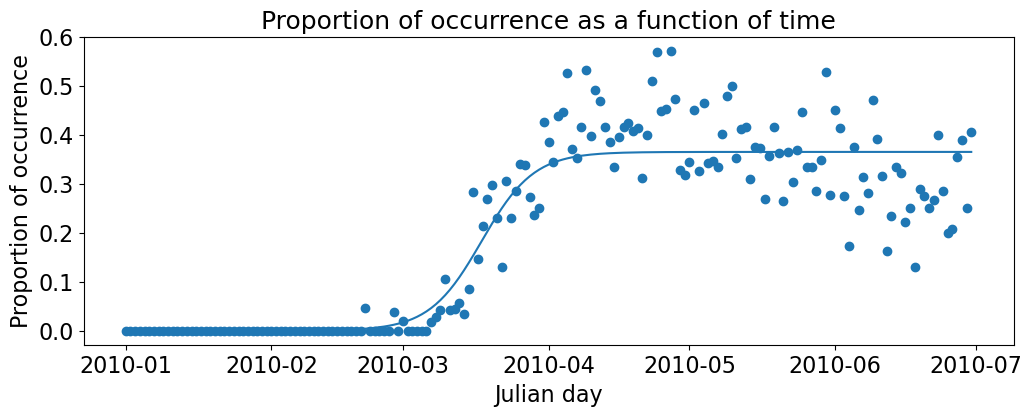

(grid_cell, year) = (120, 2011)
r_squared = 0.7776352414676255
m_a_date_round = 2011-03-16


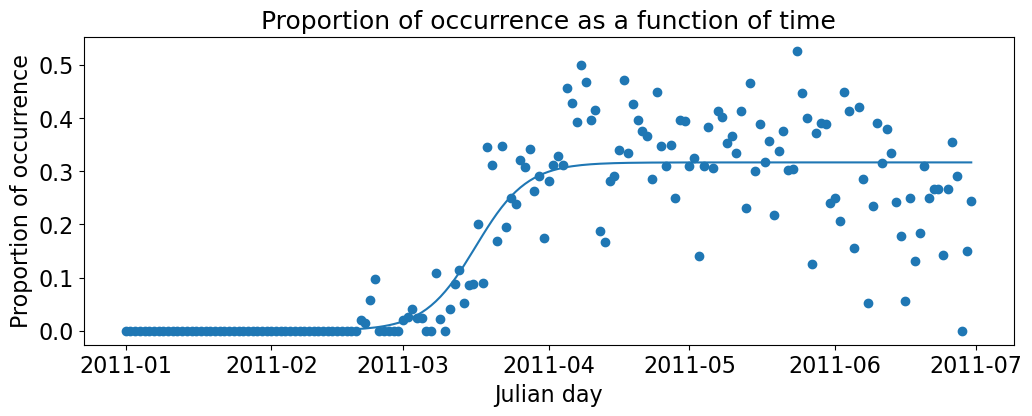

(grid_cell, year) = (120, 2012)
r_squared = 0.8410530160754236
m_a_date_round = 2012-03-16


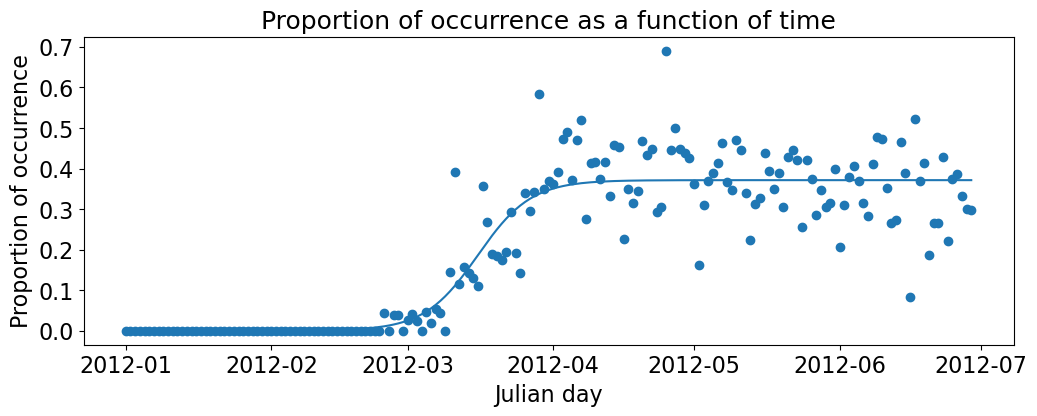

(grid_cell, year) = (120, 2013)
r_squared = 0.8309409524591964
m_a_date_round = 2013-03-26


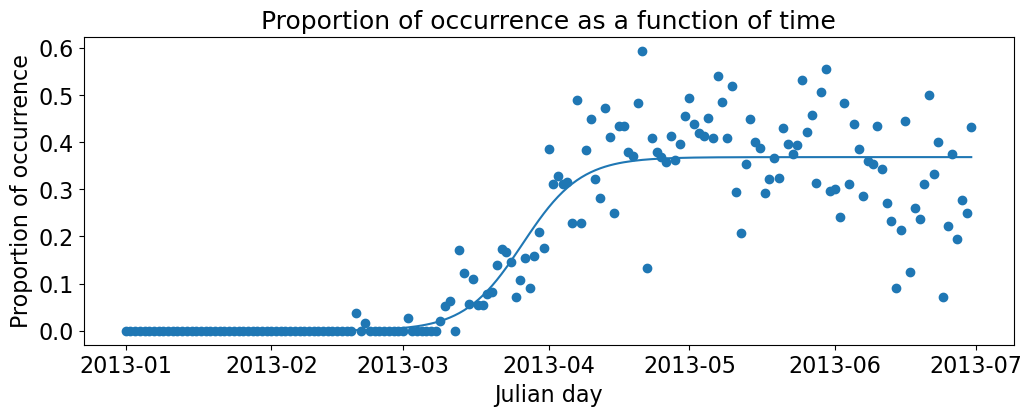

(grid_cell, year) = (120, 2014)
r_squared = 0.8197057579546864
m_a_date_round = 2014-03-26


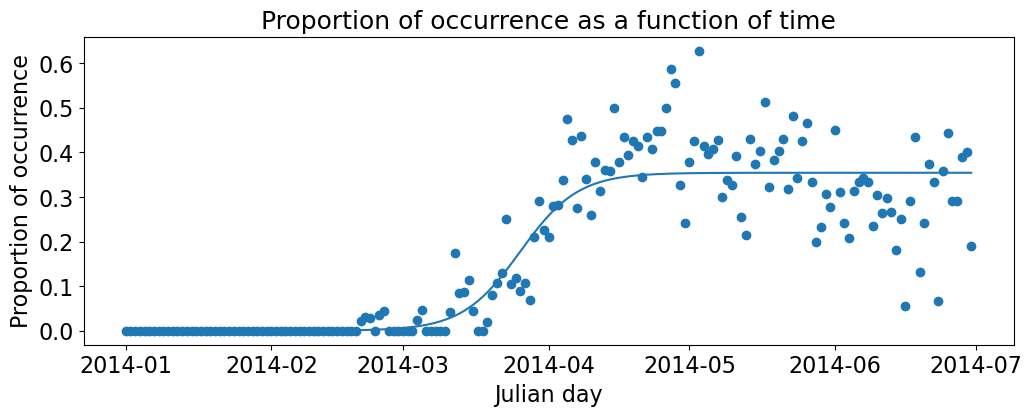

(grid_cell, year) = (120, 2015)
r_squared = 0.8804727844359272
m_a_date_round = 2015-03-28


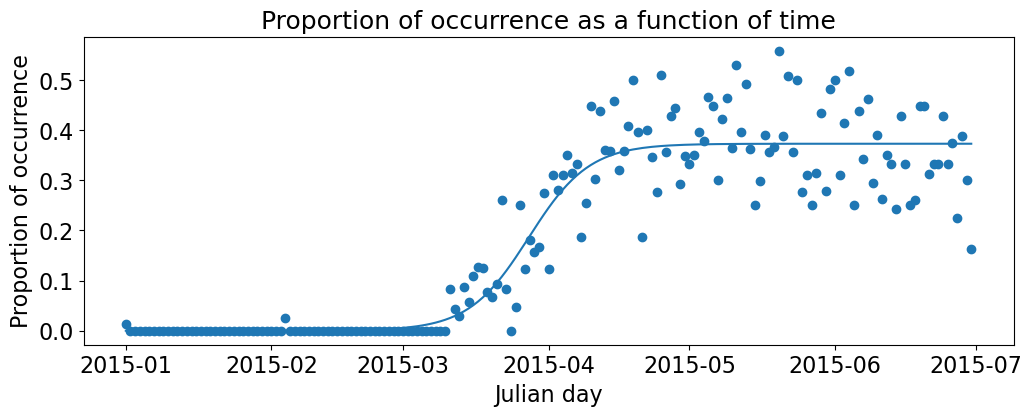

(grid_cell, year) = (120, 2016)
r_squared = 0.850136610647304
m_a_date_round = 2016-03-18


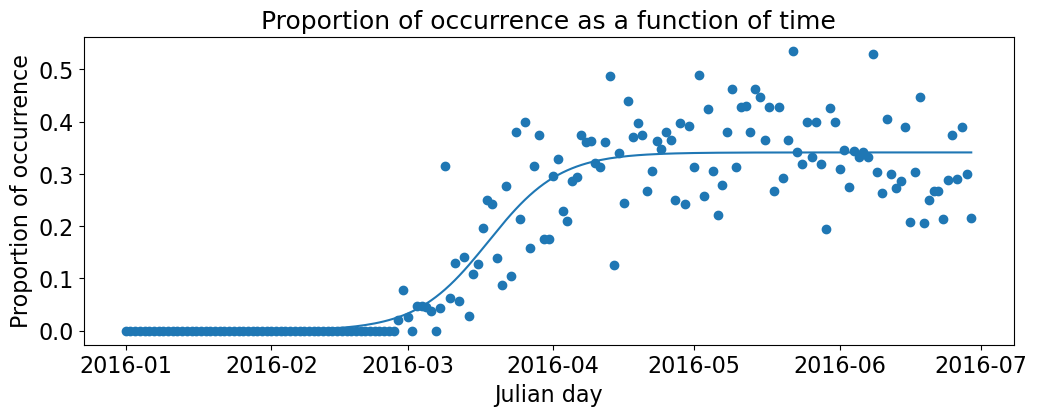

(grid_cell, year) = (120, 2017)
r_squared = 0.8796203635317175
m_a_date_round = 2017-03-26


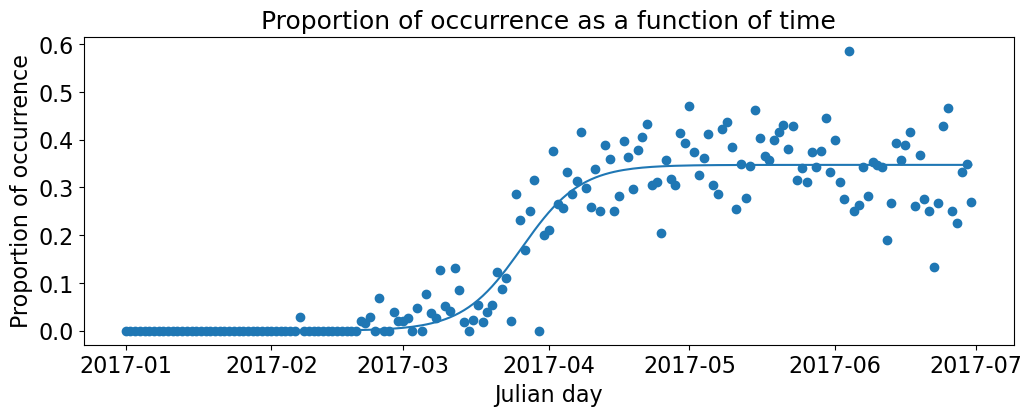

(grid_cell, year) = (120, 2018)
r_squared = 0.8691910884817294
m_a_date_round = 2018-03-27


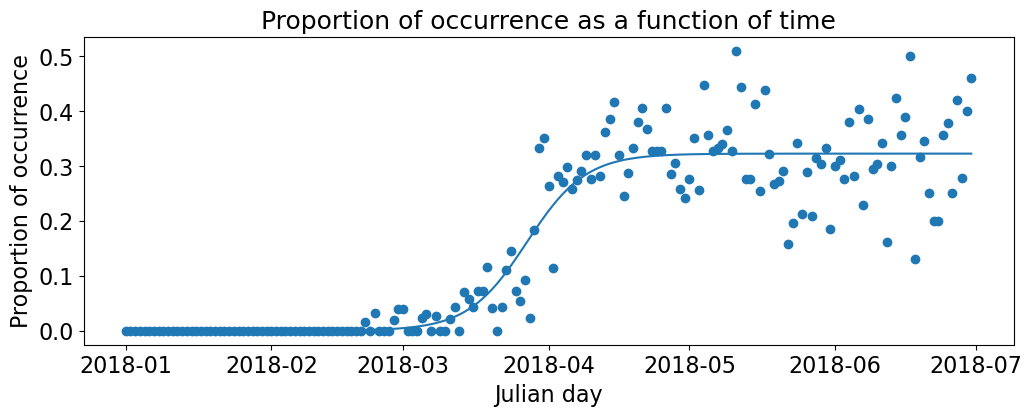

(grid_cell, year) = (120, 2019)
r_squared = 0.8328888606871421
m_a_date_round = 2019-03-24


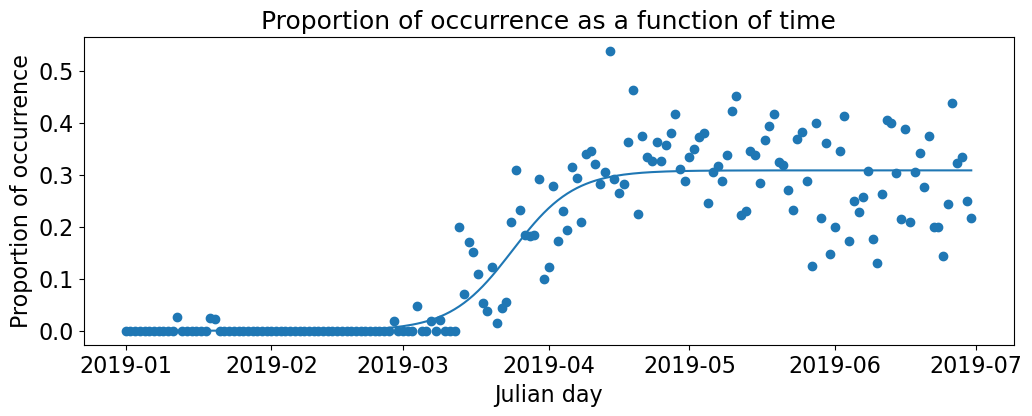

0
len(df_logistic) = 10
filename = ebd_US_states_east_Mississippi_treswa_0101_0731_complete_zerofilled_grid_cell_120_proportions_mean_2010_2019_sampled_1_relApr-2020.csv


In [14]:
analysis = 'mean_arrival_day_sampling_grid_cell'

arrival_day = 'mean'

species = 'treswa'
# species = 'barswa'
# species = 'chiswi'

first_year = 2002

# start_year = '2002'
# start_year = '2003'

start_year = '2010'
# start_year = '2012'
# start_year = '2009'
    
# start_year = '2015'
# start_year = '2014'

grid_cell = 120
# grid_cell = 128
# grid_cell = 136

# grid_cell = 117
# grid_cell = 147
# grid_cell = 151

actual_start_date = '0101'
actual_end_date = '0630'

sampled = 1

random_state = 1

# df_sampled, df_prop_greater_than_cnt_sampled, df_grid_cells_years_sampled, df_block_year_sampled, \
# df_first_of_season_sampled = get_arrival_days(
#     species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#     countries_states, random_state)

df_sampled, df_prop_greater_than_cnt_sampled, df_grid_cells_years_sampled, df_block_year_sampled, \
df_logistic_sampled = get_arrival_days(
    species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
    countries_states, random_state)

# for random_state in range(1, 6):
    
#     df_sampled, df_prop_greater_than_cnt_sampled, df_grid_cells_years_sampled, df_block_year_sampled, \
#     df_first_of_season_sampled = get_arrival_days(
#         species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#         countries_states, random_state)

# for start_year in range(first_year, end_year + 1):
    
#     start_year = str(start_year)
#     print('start_year =', start_year)
    
#     end_year = str(end_year)

#     df_sampled, df_prop_greater_than_cnt_sampled, df_grid_cells_years_sampled, df_block_year_sampled, \
#     df_first_of_season_sampled = get_arrival_days(
#         species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#         countries_states, random_state)

filename = ebd_US_states_east_Mississippi_treswa_0101_0731_complete_zerofilled_grid_cell_120_proportions_2010_2019_not_sampled_relApr-2020.csv
len(df) = 1810
len(df_prop_greater_than): 1279
len(df_prop_greater_than_cnt): 10
len(list_grid_cells) = 10
len(list(set(list_grid_cells))) = 1
(grid_cell, year) = (120, 2010)
r_squared = 0.8622056471900355
m_a_date_round = 2010-03-18


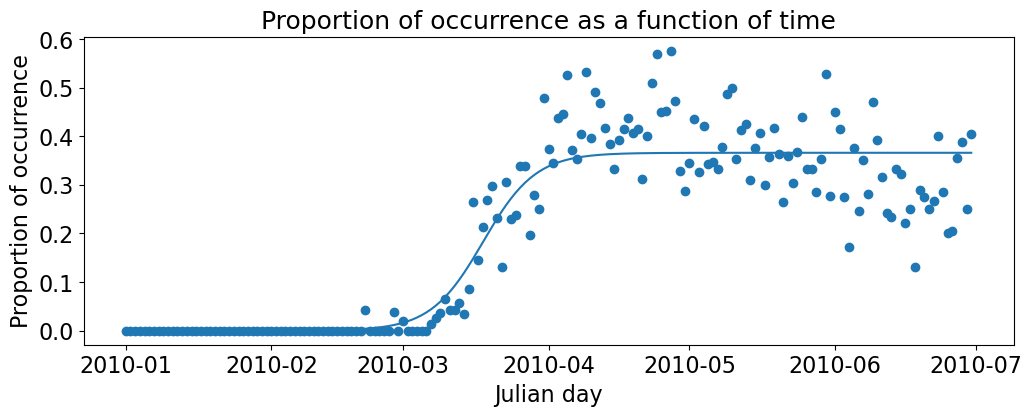

(grid_cell, year) = (120, 2011)
r_squared = 0.8569074835515254
m_a_date_round = 2011-03-17


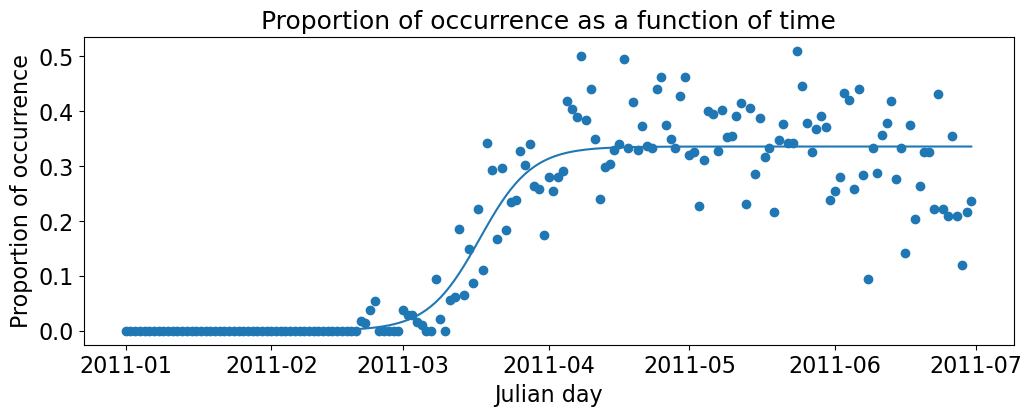

(grid_cell, year) = (120, 2012)
r_squared = 0.9330412232580813
m_a_date_round = 2012-03-17


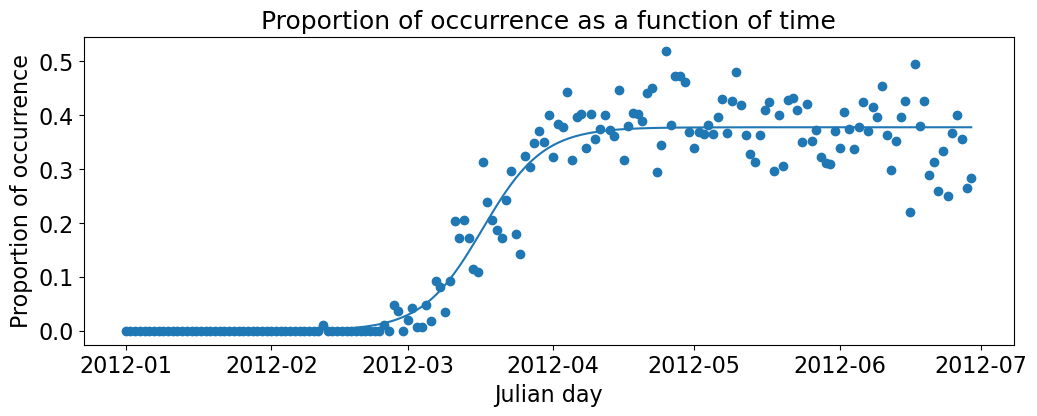

(grid_cell, year) = (120, 2013)
r_squared = 0.903038461759669
m_a_date_round = 2013-03-26


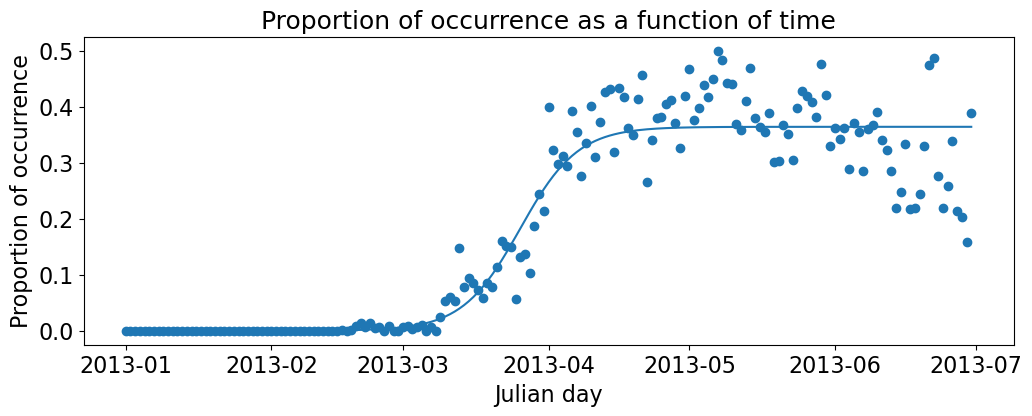

(grid_cell, year) = (120, 2014)
r_squared = 0.9102516147589313
m_a_date_round = 2014-03-27


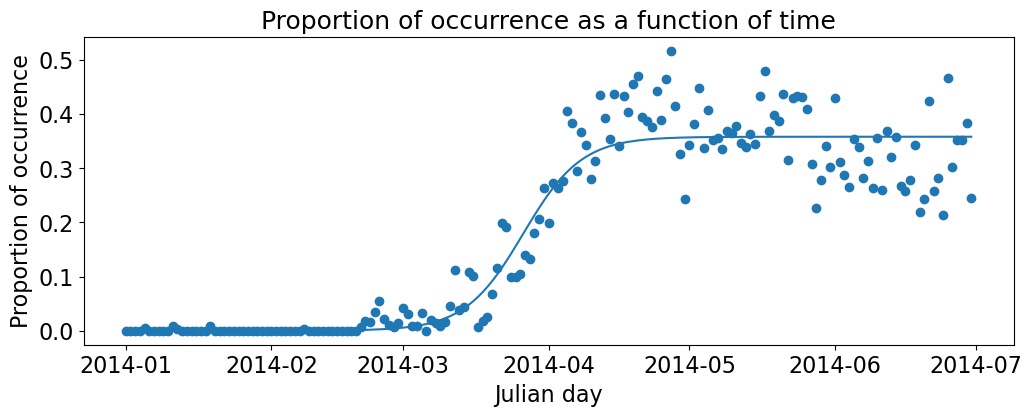

(grid_cell, year) = (120, 2015)
r_squared = 0.9486443342872162
m_a_date_round = 2015-03-28


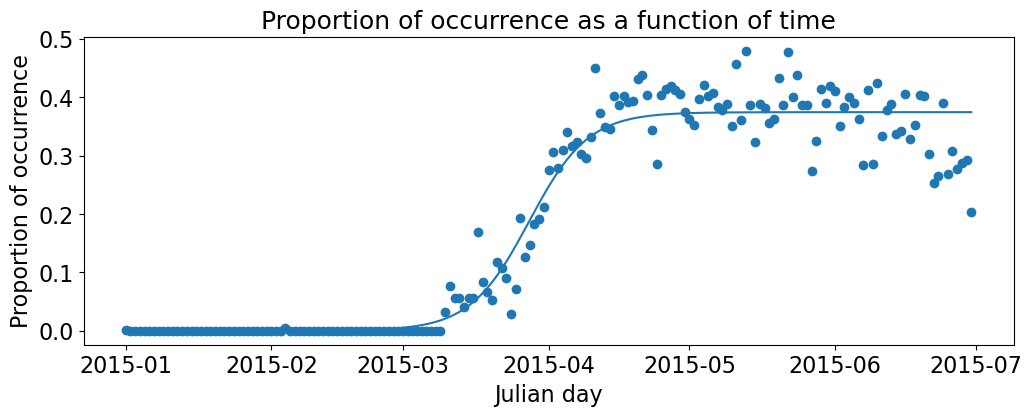

(grid_cell, year) = (120, 2016)
r_squared = 0.945431726875324
m_a_date_round = 2016-03-19


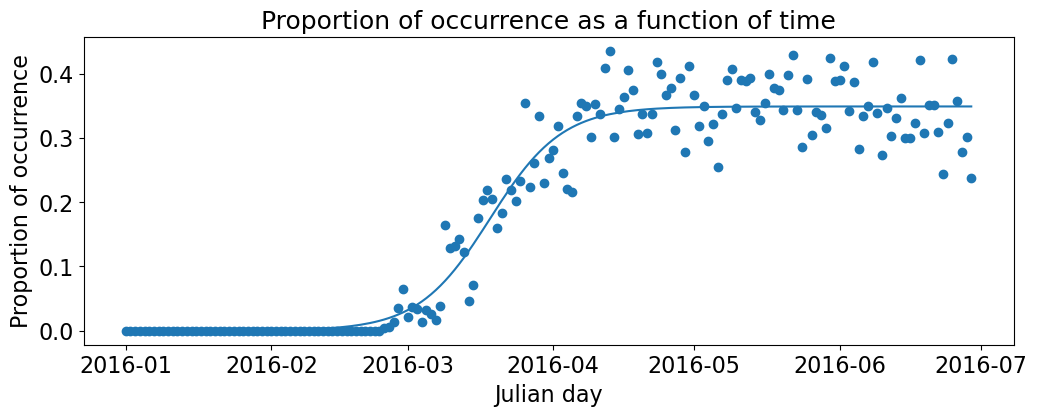

(grid_cell, year) = (120, 2017)
r_squared = 0.9480040553758724
m_a_date_round = 2017-03-26


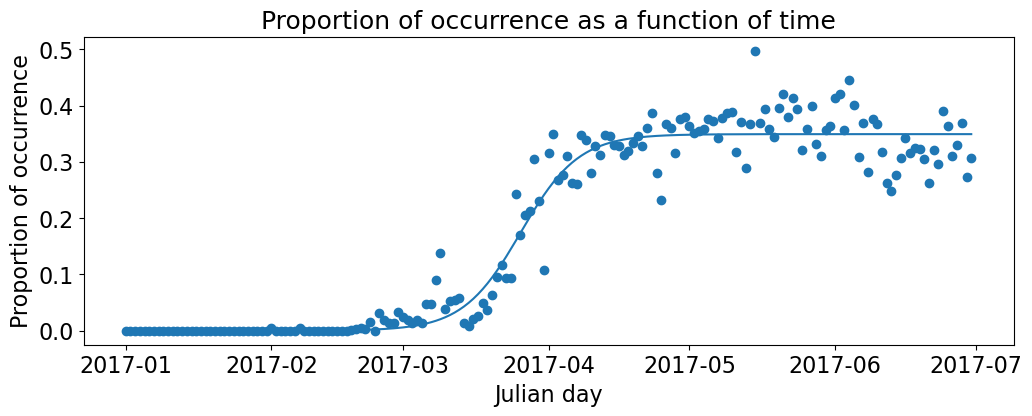

(grid_cell, year) = (120, 2018)
r_squared = 0.9334728360593755
m_a_date_round = 2018-03-26


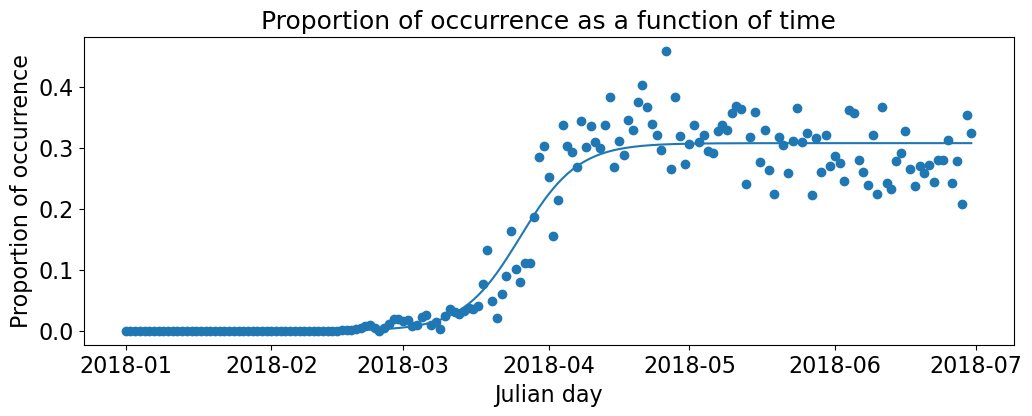

(grid_cell, year) = (120, 2019)
r_squared = 0.9347644519168
m_a_date_round = 2019-03-24


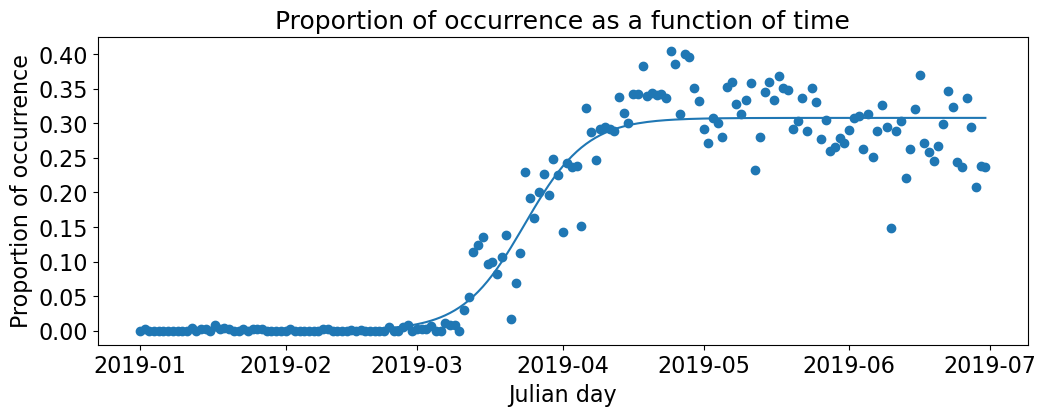

0
len(df_logistic) = 10
filename = ebd_US_states_east_Mississippi_treswa_0101_0731_complete_zerofilled_grid_cell_120_proportions_mean_2010_2019_not_sampled_relApr-2020.csv


In [15]:
sampled = 0

# df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, df_block_year_not_sampled, \
# df_first_of_season_not_sampled = get_arrival_days(
#     species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, countries_states)

df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, df_block_year_not_sampled, \
df_logistic_not_sampled = get_arrival_days(
    species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
    countries_states)

# for start_year in range(first_year, end_year + 1):
    
#     start_year = str(start_year)
#     print('start_year =', start_year)
    
#     end_year = str(end_year)

#     df_not_sampled, df_prop_greater_than_cnt_not_sampled, df_grid_cells_years_not_sampled, \
#     df_block_year_not_sampled, df_first_of_season_not_sampled = get_arrival_days(
#         species, start_date, end_date, start_year, end_year, month, year_ebird, sampled, analysis, arrival_day, 
#         countries_states)

In [ ]:
df_sampled.head(2)

In [ ]:
df_not_sampled.head(2)

In [ ]:
df_prop_greater_than_cnt_sampled.head(2)

In [ ]:
df_prop_greater_than_cnt_sampled['nb_prop'].value_counts().to_frame().reset_index().sort_values(by='index')

In [ ]:
df_prop_greater_than_cnt_not_sampled.head(2)

In [ ]:
df_grid_cells_years_sampled.head(2)

In [ ]:
df_grid_cells_years_not_sampled.head(2)

In [ ]:
df_block_year_sampled.head(2)

In [ ]:
df_block_year_not_sampled.head(2)

In [ ]:
df_first_of_season_sampled.head(2)

In [ ]:
df_first_of_season_not_sampled.head(2)

In [ ]:
# df_logistic_sampled.head(2)

In [ ]:
# df_logistic_not_sampled.head(2)

In [ ]:
# df['nb_checklists'].value_counts(sort=False).to_frame().reset_index().sort_values(by=['index']).rename(
#     columns={'index': 'nb_checklists', 'nb_checklists': 'cnt_grid_cells_observation_dates'}).head(2)

In [ ]:
# df_cnt_years = df['year'].value_counts(sort=False).to_frame().reset_index()
# df_cnt_years = df_cnt_years.rename(columns={'index': 'year', 'year': 'cnt_grid_cells_dates'})

In [ ]:
# df_cnt_years.head(2)

In [ ]:
# subdir = 'eBird/ebd_output/'

# filename = 'ebd_' + countries_states + '_' + species + '_' + start_date + '_' + end_date + \
# '_complete_zerofilled_grid_cells_proportions_cnt_years_rel' + month + '-' + year_ebird + '.csv'
# print(filename)
        
# df_cnt_years.to_csv(subdir + filename, index=False)

In [ ]:
# species_cnt = 0

# for i in range(len(df_species_codes)):
    
#     print(i)
  
#     species = df_species_codes['species_code'].iloc[i]
#     print(species)
    
#     if ((species == 'souwpw1') | (species == 'bucnig') | (species == 'compoo') | (species == 'whtswi') | 
#         (species == "blkswi") | (species == "treswa")): #
#         continue
    
#     df, df_cnt_checklists, df_cnt_checklists_species, df_prop_greater_than, df_prop_greater_than_cnt, \
# df_subset = get_arrival_days(species, start_date, end_date, month, year_ebird, countries_states)
    
#     species_cnt += 1

In [ ]:
# print(species_cnt)